# Tool creation for RAG agents with langgraph 
To create tools for RAG agents using LangGraph, you're essentially building LLM-invocable functions that your agent can call as part of its reasoning + acting loop (ReAct).

LangGraph uses the Tool abstraction from LangChain and fully supports tools for:

- RAG retrieval
- Search
- Wikipedia
- SQL
- Web APIs
- Calculators, etc.

## ✅ Tool Design Requirements
A LangGraph tool must:

- Have a name
- Have a description (used by the LLM to decide when to use it)
- Have a callable func, accepting a single input (usually str) and returning str

## Setup and Import Libraries

In [ ]:
import os
from typing import Annotated, TypedDict, Sequence
from langchain.agents import Tool
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import ArxivLoader, TextLoader
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.messages import BaseMessage, HumanMessage
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from langgraph.graph import END
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
load_dotenv()

True

In [3]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [4]:
embedding = OpenAIEmbeddings()
llm = init_chat_model("openai:gpt-4o")

## Creating Multiple Tools

### Creating Retriever Tool

In [5]:
def make_retriever_tool_from_text(file, tool_name, description):
    documents = TextLoader(file, encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(documents=documents)
    vector_store = FAISS.from_documents(documents=chunks, embedding=embedding)
    retriever = vector_store.as_retriever()

    def tool_func(query:str)->str:
        print(f"📚 Using tool: {tool_name}")
        results = retriever.invoke(input=query)
        return "\n\n".join(result.page_content for result in results)
    
    return Tool(name=tool_name, description=description, func=tool_func)

### Creating Wikipedia Tool

In [7]:
wikipedia_tool = Tool(
    name="Wikipedia",
    description="Use this tool to fetch general world knowledge from Wikipedia.",
    func=WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
)

### Creating Arxiv Tool

In [8]:
def arxiv_search(query: str) -> str:
    print("🧪 Searching ArXiv...")
    results = ArxivLoader(query=query).load()
    return "\n\n".join(result.page_content[:1000] for result in results[:2]) or "No papers found."

arxiv_tool = Tool(
    name="ArxivSearch",
    description="Use this tool to fetch recent academic papers on technical topics.",
    func=arxiv_search
)

### Creating Tools using Retriever Tool

In [9]:
internel_document_tool = make_retriever_tool_from_text(
    file="internal_docs.txt",
    tool_name="InternalTechDocs",
    description="Search internal tech documents for proprietary architecture and methods."
)

internel_document_tool

Tool(name='InternalTechDocs', description='Search internal tech documents for proprietary architecture and methods.', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x0000022A01126FC0>)

In [10]:
research_notes_tool = make_retriever_tool_from_text(
    file="research_notes.txt",
    tool_name="InternalResearchNotes",
    description="Search internal research notes for experimental results and agent designs."
)

research_notes_tool

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results and agent designs.', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x0000022A0113EA20>)

## Creating ReAct Node

In [12]:
tools=[
    wikipedia_tool, arxiv_tool, 
    internel_document_tool, research_notes_tool
]

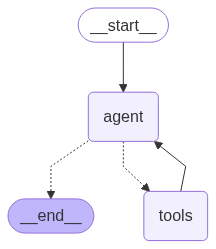

In [13]:
react_node = create_react_agent(
    model=llm, tools=tools
)

react_node

## Build Graph

In [14]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

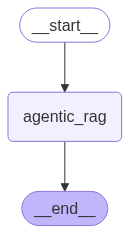

In [15]:
graph = StateGraph(AgentState)

# Add Nodes
graph.add_node(node="agentic_rag", action=react_node)

# Set Entry Point
graph.set_entry_point(key="agentic_rag")

# Add Edges
graph.add_edge(start_key="agentic_rag", end_key=END)

# Compile Graph
compiled_graph = graph.compile()

# Display Graph
compiled_graph

In [16]:
query = "What do our internal research notes say about transformer variants, and what does ArXiv suggest recently?"

state = {"messages": [HumanMessage(content=query)]}
result = compiled_graph.invoke(input=state)

print("\n✅ Final Answer:\n", result["messages"][-1].content)

📚 Using tool: InternalResearchNotes
🧪 Searching ArXiv...

✅ Final Answer:
 Here's what our internal research notes say about transformer variants, along with a recent update from ArXiv on the topic:

### Internal Research Notes:
1. **EfficientFormer:**
   - Achieved a top-1 accuracy of 92.4% on TinyImageNet.
   - Peak memory usage of 290MB with a batch size of 16.
   - Deployed on Raspberry Pi 4 and performs well in quantized int8 mode with no significant drop in accuracy.

2. **Longformer:**
   - Evaluated on customer support logs with a maximum of 8192 tokens.
   - Experienced latency greater than 1.2 seconds per query in a streaming setting.
   - Chunk-based hybrid attention may help in reducing delays.

3. **Reformer:**
   - Faced challenges such as bucket collisions, inconsistent loss spikes after 5k steps, and sparse gradient updates during LSH attention.
   - Attempted solutions include gradient clipping, warmup scheduler, and memory-efficient attention modules.

4. **TinyBERT:*